# Cross-Algorithm DNA Pattern Matching Benchmark
This notebook benchmarks five exact string-matching algorithms—Boyer–Moore, KMP, Shift-Or (Bitap), Suffix Array search, and an exact-distance Levenshtein variant—across shared DNA datasets. It records runtime and memory metrics, builds comparative dashboards, and exposes motif-highlighting utilities for biological sequence inspection.

## 1. Data & Environment Setup
Mount the `dataset/` directory (falling back to module-specific folders when necessary), inspect FASTA metadata, and load helper libraries. Path parameters are exposed through `ipywidgets` so VS Code users can swap datasets or adjust prefix lengths without editing code.

In [2]:
from __future__ import annotations

import gc
import os
import random
import sys
import textwrap
import time
from pathlib import Path
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import psutil
import seaborn as sns
import tracemalloc
from IPython.display import display
from ipywidgets import Dropdown, IntSlider, SelectMultiple, VBox

sns.set_theme(style="whitegrid", context="talk")
plt.rcParams.update({"figure.autolayout": True})

try:
    NOTEBOOK_DIR = Path(__file__).resolve().parent
except NameError:
    NOTEBOOK_DIR = Path.cwd()

REPO_ROOT = NOTEBOOK_DIR
if str(REPO_ROOT) not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))

FASTA_EXTENSIONS = (".fasta", ".fa", ".fna", ".ffn", ".faa", ".frn")
DATASET_ROOT_CANDIDATES = [
    REPO_ROOT / "dataset",
    REPO_ROOT / "Boyer_Moore" / "dataset",
    REPO_ROOT / "Shift_or_bitap" / "synthetic_datasets",
    REPO_ROOT / "Suffix Arrays-Trees" / "dataset",
]
MAX_DATASETS = 5

def _gather_from_root(root: Path, limit: int) -> List[Dict[str, object]]:
    records: List[Dict[str, object]] = []
    if not root.exists():
        return records
    for ext in FASTA_EXTENSIONS:
        for path in root.rglob(f"*{ext}"):
            records.append({
                "dataset_name": path.name,
                "root": str(root),
                "path": str(path.resolve()),
                "size_bytes": path.stat().st_size,
            })
            if len(records) >= limit:
                return records
    return records

def discover_fasta_files() -> pd.DataFrame:
    primary_root = REPO_ROOT / "dataset"
    records = _gather_from_root(primary_root, MAX_DATASETS)
    if not records:
        # fall back to other module datasets but continue to short-circuit after limit
        for alt_root in DATASET_ROOT_CANDIDATES[1:]:
            records.extend(_gather_from_root(alt_root, MAX_DATASETS - len(records)))
            if len(records) >= MAX_DATASETS:
                break
    if not records:
        raise FileNotFoundError(
            "No FASTA/FNA files discovered. Add genomes under the top-level dataset/ folder before continuing.",
        )
    df = pd.DataFrame(records).sort_values("dataset_name").reset_index(drop=True)
    return df

def read_fasta_contiguous(filepath: Path) -> str:
    seq_parts: List[str] = []
    with filepath.open() as handle:
        for line in handle:
            line = line.strip()
            if not line or line.startswith(">"):
                continue
            seq_parts.append(line.upper())
    return "".join(seq_parts)

DATASET_FRAME = discover_fasta_files()
unique_roots = DATASET_FRAME["root"].unique().tolist()
root_dropdown = Dropdown(options=unique_roots, value=unique_roots[0], description="dataset root")
max_prefix_slider = IntSlider(value=120_000, min=10_000, max=300_000, step=10_000, description="prefix bp")
selector = SelectMultiple(
    options=[(row.dataset_name, row.dataset_name) for row in DATASET_FRAME.itertuples()],
    value=tuple(DATASET_FRAME.head(2)["dataset_name"].tolist()),
    description="datasets",
    layout={"width": "70%"},
)

controls = VBox([root_dropdown, max_prefix_slider, selector])
display(controls)
print(
    f"Discovered {len(DATASET_FRAME)} FASTA-like files (limited to the first {MAX_DATASETS} in repo dataset/)."
)
DATASET_FRAME.head()

Discovered 5 FASTA-like files (limited to the first 5 in repo dataset/).


,dataset_name,root,path,size_bytes
0,GCA_000517165.1_ASM51716v1_genomic.fna,/home/shivek-gupta/Desktop/Sem3/AAD/Levenshtei...,/home/shivek-gupta/Desktop/Sem3/AAD/Levenshtei...,4622807
1,GCA_949550125.1_sample3_Strain151_Lambda.fasta...,/home/shivek-gupta/Desktop/Sem3/AAD/Levenshtei...,/home/shivek-gupta/Desktop/Sem3/AAD/Levenshtei...,4672839
2,GCF_045343875.1_ASM4534387v1_genomic.fna,/home/shivek-gupta/Desktop/Sem3/AAD/Levenshtei...,/home/shivek-gupta/Desktop/Sem3/AAD/Levenshtei...,4655121
3,GCF_949549225.1_sample6_Strain153_PhageHK022.f...,/home/shivek-gupta/Desktop/Sem3/AAD/Levenshtei...,/home/shivek-gupta/Desktop/Sem3/AAD/Levenshtei...,4715926
4,SYNTH_20251118T040414_GFEG_genomic.fna,/home/shivek-gupta/Desktop/Sem3/AAD/Levenshtei...,/home/shivek-gupta/Desktop/Sem3/AAD/Levenshtei...,202919


## 2. Algorithm Loader & Exact-Match Wrappers
Load each implementation from its folder, normalize function signatures, and guard Shift-Or to 64 bp so all runners behave predictably.

In [3]:
import importlib.util

SUFFIX_ARRAYS_DIR = REPO_ROOT / "Suffix Arrays-Trees"
SUFFIX_ARRAY_MODULE = SUFFIX_ARRAYS_DIR / "suffix_array.py"
if not SUFFIX_ARRAY_MODULE.exists():
    raise FileNotFoundError(
        "Expected Suffix Arrays-Trees/suffix_array.py to exist before importing algorithms.",
    )
suffix_spec = importlib.util.spec_from_file_location(
    "suffix_arrays_trees.suffix_array", str(SUFFIX_ARRAY_MODULE)
 )
suffix_array_module = importlib.util.module_from_spec(suffix_spec)
suffix_spec.loader.exec_module(suffix_array_module)
manber_myers_suffix_array = suffix_array_module.manber_myers_suffix_array
locate_pattern = suffix_array_module.locate_pattern

from Boyer_Moore.boyer_moore import BoyerMoore
from KMP.kmp import KMP
from Shift_or_bitap.shift_or_exact import ShiftOrExact

def ensure_text(dataset_name: str, max_len: int) -> str:
    row = DATASET_FRAME[DATASET_FRAME["dataset_name"] == dataset_name].iloc[0]
    text = read_fasta_contiguous(Path(row["path"]))
    return text[:max_len]

def run_boyer_moore(text: str, pattern: str) -> List[int]:
    return BoyerMoore(pattern).search(text)

def run_kmp(text: str, pattern: str) -> List[int]:
    return KMP(pattern).search(text)

def run_shift_or(text: str, pattern: str) -> List[int]:
    if len(pattern) > 64:
        raise ValueError("Shift-Or exact is limited to 64bp patterns.")
    return ShiftOrExact(pattern).search(text)

_suffix_array_cache: Dict[Tuple[str, int], List[int]] = {}

def run_suffix_array(dataset_name: str, text: str, pattern: str) -> List[int]:
    cache_key = (dataset_name, len(text))
    if cache_key not in _suffix_array_cache:
        _suffix_array_cache[cache_key] = manber_myers_suffix_array(text)
    suffix_array = _suffix_array_cache[cache_key]
    return locate_pattern(text, pattern, suffix_array)

def fuzzy_levenshtein_search(text: str, pattern: str, k: int) -> List[int]:
    """
    Finds all matches with at most 'k' Levenshtein edits using dynamic programming.
    Time: O(n*m), Space: O(n) where n=len(text), m=len(pattern)
    """
    n = len(text)
    m = len(pattern)
    matches = []
    
    if m == 0 or n == 0:
        return matches
    
    # Initialize DP table with single row (space optimization)
    previous_row = [0] * (n + 1)
    
    for i in range(1, m + 1):
        current_row = [i] * (n + 1)
        for j in range(1, n + 1):
            deletion = previous_row[j] + 1
            insertion = current_row[j - 1] + 1
            substitution = previous_row[j - 1] + (0 if pattern[i - 1] == text[j - 1] else 1)
            current_row[j] = min(deletion, insertion, substitution)
        
        # On the last row, check for matches within k edits
        if i == m:
            for j in range(1, n + 1):
                if current_row[j] <= k:
                    matches.append(j - m)
        
        previous_row = current_row
    
    return matches

def run_levenshtein_exact(text: str, pattern: str) -> List[int]:
    """Exact matching using Levenshtein with k=0 (no edits allowed)"""
    return fuzzy_levenshtein_search(text, pattern, k=0)

ALGORITHM_REGISTRY: List[Dict[str, object]] = [
    {"name": "Boyer-Moore", "runner": run_boyer_moore, "supports": lambda pattern: True},
    {"name": "KMP", "runner": run_kmp, "supports": lambda pattern: True},
    {"name": "Shift-Or", "runner": run_shift_or, "supports": lambda pattern: len(pattern) <= 64},
    {"name": "Suffix Array", "runner": run_suffix_array, "supports": lambda pattern: True},
    {"name": "Levenshtein (Exact)", "runner": run_levenshtein_exact, "supports": lambda pattern: True},
]

## 3. Benchmark Configuration & DNA Pattern Selection
Sample motifs of varying lengths per dataset, compute GC content, and assemble a configuration table that powers all experiments.

In [4]:
PATTERN_LENGTHS = [8, 16, 32]
RNG = random.Random(42)
TEXT_CACHE: Dict[str, str] = {}

def compute_gc_content(seq: str) -> float:
    if not seq:
        return 0.0
    seq = seq.upper()
    gc = seq.count("G") + seq.count("C")
    return 100 * gc / len(seq)

def sample_patterns(selected_names: List[str], max_len: int) -> pd.DataFrame:
    records: List[Dict[str, object]] = []
    for name in selected_names:
        text = ensure_text(name, max_len)
        TEXT_CACHE[name] = text
        for length in PATTERN_LENGTHS:
            if len(text) <= length:
                continue
            start = RNG.randrange(0, len(text) - length)
            pattern = text[start : start + length]
            records.append({
                "dataset_name": name,
                "pattern": pattern,
                "pattern_length": length,
                "gc_content": compute_gc_content(pattern),
                "text_length": len(text),
                "start_index": start,
            })
    config = pd.DataFrame(records)
    if config.empty:
        raise ValueError("No valid pattern scenarios. Increase prefix length or add more datasets.")
    return config

selected_datasets = list(selector.value)
if not selected_datasets:
    raise ValueError("Select at least one dataset via the widget before sampling patterns.")

benchmark_config = sample_patterns(selected_datasets, max_prefix_slider.value)
print(f"Prepared {len(benchmark_config)} pattern scenarios across {len(selected_datasets)} dataset(s).")
benchmark_config.head()

Prepared 6 pattern scenarios across 2 dataset(s).


,dataset_name,pattern,pattern_length,gc_content,text_length,start_index
0,GCA_000517165.1_ASM51716v1_genomic.fna,TTCTTCAG,8,37.500,120000,83810
1,GCA_000517165.1_ASM51716v1_genomic.fna,CGCTCTTCCGGGCGTA,16,68.750,120000,14592
2,GCA_000517165.1_ASM51716v1_genomic.fna,AAAACAACAATTTATATTGAAATTATTAAACG,32,15.625,120000,3278
3,GCA_949550125.1_sample3_Strain151_Lambda.fasta...,TCTTTCGG,8,50.000,120000,97196
4,GCA_949550125.1_sample3_Strain151_Lambda.fasta...,TGGTGGAATGCAAACA,16,43.750,120000,36048


## 4. Execution Time Benchmarking Loop
Warm up each algorithm, capture timings in milliseconds, and track match counts for verification.

In [5]:
def time_algorithm(algorithm: Dict[str, object], dataset_name: str, text: str, pattern: str) -> Tuple[float, List[int]]:
    runner = algorithm["runner"]
    # warm-up to stabilize caches
    if algorithm["name"] == "Suffix Array":
        runner(dataset_name, text, pattern)
        start_ns = time.perf_counter_ns()
        matches = runner(dataset_name, text, pattern)
    else:
        runner(text, pattern)
        start_ns = time.perf_counter_ns()
        matches = runner(text, pattern)
    elapsed_ms = (time.perf_counter_ns() - start_ns) / 1e6
    return elapsed_ms, matches

def benchmark_runtime(config: pd.DataFrame) -> pd.DataFrame:
    rows: List[Dict[str, object]] = []
    for record in config.itertuples():
        text = TEXT_CACHE[record.dataset_name]
        for alg in ALGORITHM_REGISTRY:
            if not alg["supports"](record.pattern):
                rows.append({
                    "dataset_name": record.dataset_name,
                    "algorithm": alg["name"],
                    "pattern": record.pattern,
                    "pattern_length": record.pattern_length,
                    "text_length": record.text_length,
                    "gc_content": record.gc_content,
                    "time_ms": np.nan,
                    "match_count": np.nan,
                    "note": "unsupported pattern length",
                })
                continue
            elapsed_ms, matches = time_algorithm(alg, record.dataset_name, text, record.pattern)
            rows.append({
                "dataset_name": record.dataset_name,
                "algorithm": alg["name"],
                "pattern": record.pattern,
                "pattern_length": record.pattern_length,
                "text_length": record.text_length,
                "gc_content": record.gc_content,
                "time_ms": elapsed_ms,
                "match_count": len(matches),
                "note": "",
            })
    return pd.DataFrame(rows)

runtime_results = benchmark_runtime(benchmark_config)
runtime_results.head()

,dataset_name,algorithm,pattern,pattern_length,text_length,gc_content,time_ms,match_count,note
0,GCA_000517165.1_ASM51716v1_genomic.fna,Boyer-Moore,TTCTTCAG,8,120000,37.5,15.985552,3,
1,GCA_000517165.1_ASM51716v1_genomic.fna,KMP,TTCTTCAG,8,120000,37.5,14.530896,3,
2,GCA_000517165.1_ASM51716v1_genomic.fna,Shift-Or,TTCTTCAG,8,120000,37.5,23.683354,107584,
3,GCA_000517165.1_ASM51716v1_genomic.fna,Suffix Array,TTCTTCAG,8,120000,37.5,0.015624,3,
4,GCA_000517165.1_ASM51716v1_genomic.fna,Levenshtein (Exact),TTCTTCAG,8,120000,37.5,260.516964,3,


## 5. Memory Profiling Harness
Use `tracemalloc` plus `psutil` RSS deltas to capture peak and average memory footprint per algorithm-pattern pair.

In [6]:
def memory_profile(config: pd.DataFrame) -> pd.DataFrame:
    process = psutil.Process(os.getpid())
    rows: List[Dict[str, object]] = []
    for record in config.itertuples():
        text = TEXT_CACHE[record.dataset_name]
        for alg in ALGORITHM_REGISTRY:
            if not alg["supports"](record.pattern):
                rows.append({
                    "dataset_name": record.dataset_name,
                    "algorithm": alg["name"],
                    "pattern_length": record.pattern_length,
                    "text_length": record.text_length,
                    "peak_kb": np.nan,
                    "avg_kb": np.nan,
                })
                continue
            runner = alg["runner"]
            tracemalloc.start()
            rss_before = process.memory_info().rss
            if alg["name"] == "Suffix Array":
                _ = runner(record.dataset_name, text, record.pattern)
            else:
                _ = runner(text, record.pattern)
            current, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            rss_after = process.memory_info().rss
            rows.append({
                "dataset_name": record.dataset_name,
                "algorithm": alg["name"],
                "pattern_length": record.pattern_length,
                "text_length": record.text_length,
                "peak_kb": peak / 1024,
                "avg_kb": ((rss_after - rss_before) / 2 + current) / 1024,
            })
            gc.collect()
    return pd.DataFrame(rows)

memory_results = memory_profile(benchmark_config)
memory_results.head()

,dataset_name,algorithm,pattern_length,text_length,peak_kb,avg_kb
0,GCA_000517165.1_ASM51716v1_genomic.fna,Boyer-Moore,8,120000,118.641602,0.612305
1,GCA_000517165.1_ASM51716v1_genomic.fna,KMP,8,120000,118.490234,0.859375
2,GCA_000517165.1_ASM51716v1_genomic.fna,Shift-Or,8,120000,4353.408203,7055.617188
3,GCA_000517165.1_ASM51716v1_genomic.fna,Suffix Array,8,120000,93.923828,0.820312
4,GCA_000517165.1_ASM51716v1_genomic.fna,Levenshtein (Exact),8,120000,1876.152344,0.968750


## 6. Metric Aggregation & Statistical Summaries
Merge runtime and memory tables, compute descriptive statistics, and emit LaTeX-ready tables for reporting.

In [7]:
combined = pd.merge(
    runtime_results,
    memory_results,
    on=["dataset_name", "algorithm", "pattern_length", "text_length"],
    how="left",
)

summary = (
    combined.groupby("algorithm")
    .agg(
        mean_time_ms=("time_ms", "mean"),
        median_time_ms=("time_ms", "median"),
        cv_time=("time_ms", lambda s: s.std(ddof=0) / s.mean() if s.mean() else np.nan),
        mean_peak_kb=("peak_kb", "mean"),
        mean_avg_kb=("avg_kb", "mean"),
        mean_matches=("match_count", "mean"),
    )
    .reset_index()
)

latex_table = summary.to_latex(index=False, float_format="{:.3f}".format)
summary, latex_table

(             algorithm  mean_time_ms  median_time_ms   cv_time  mean_peak_kb  \
 0          Boyer-Moore     11.257398       10.860375  0.269711    119.559733   
 1                  KMP     14.612750       14.222756  0.095368    118.513672   
 2  Levenshtein (Exact)    611.883234      518.469264  0.519653   1876.656250   
 3             Shift-Or     27.264723       24.216379  0.176391   4669.631510   
 4         Suffix Array      0.012934        0.012474  0.113859     86.737956   
 
    mean_avg_kb  mean_matches  
 0     0.960124           1.5  
 1     0.812500           1.5  
 2 -2369.335286           1.5  
 3  7490.377604      115373.0  
 4     0.820312           1.5  ,
 '\\begin{tabular}{lrrrrrr}\n\\toprule\nalgorithm & mean_time_ms & median_time_ms & cv_time & mean_peak_kb & mean_avg_kb & mean_matches \\\\\n\\midrule\nBoyer-Moore & 11.257 & 10.860 & 0.270 & 119.560 & 0.960 & 1.500 \\\\\nKMP & 14.613 & 14.223 & 0.095 & 118.514 & 0.812 & 1.500 \\\\\nLevenshtein (Exact) & 611.883 & 51

## 7. Visualization Dashboard for Performance Metrics
Generate matplotlib comparisons plus an interactive Plotly dashboard to juxtapose runtime, memory, GC content, and match counts.

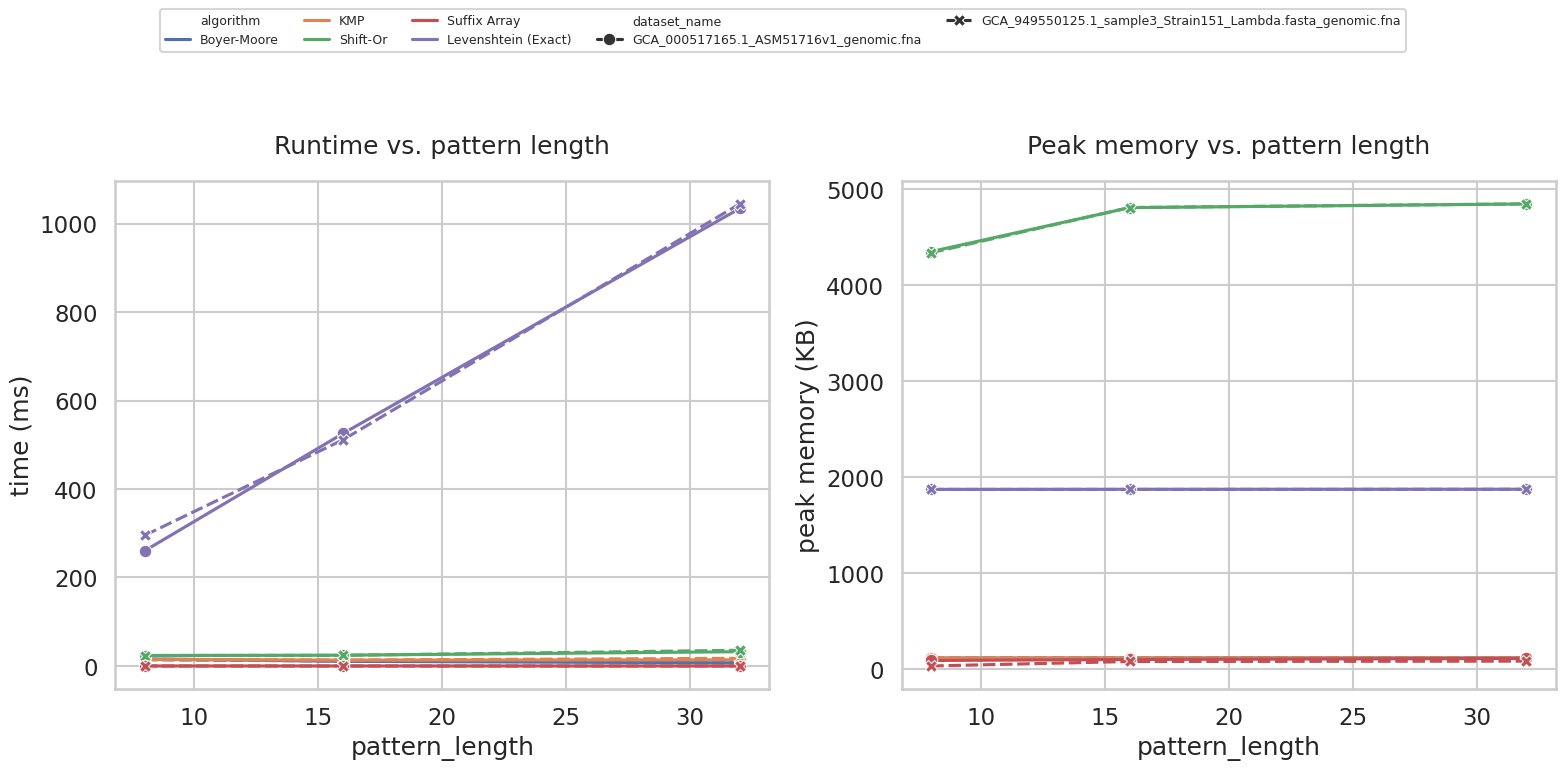

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 8))
ax_time, ax_memory = axes

sns.lineplot(
    data=combined,
    x="pattern_length",
    y="time_ms",
    hue="algorithm",
    style="dataset_name",
    markers=True,
    ax=ax_time,
)
ax_time.set_title("Runtime vs. pattern length", pad=20)
ax_time.set_ylabel("time (ms)")
ax_time.get_legend().remove()

sns.lineplot(
    data=combined,
    x="pattern_length",
    y="peak_kb",
    hue="algorithm",
    style="dataset_name",
    markers=True,
    ax=ax_memory,
)
ax_memory.set_title("Peak memory vs. pattern length", pad=20)
ax_memory.set_ylabel("peak memory (KB)")
ax_memory.get_legend().remove()

# Create a single legend at the top for both plots
handles, labels = ax_time.get_legend_handles_labels()
if handles and labels:
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.98), 
               ncol=min(5, len(labels)), fontsize=9, frameon=True)
    plt.subplots_adjust(top=0.85)

plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.show()

def safe_plotly_show(fig):
    try:
        import nbformat  # noqa: F401
    except ImportError:
        print(
            "Plotly interactive view skipped: install nbformat>=4.2.0 (e.g., `pip install nbformat`).",
        )
        return
    try:
        fig.show()
    except ValueError as exc:
        print(
            "Plotly interactive view skipped due to renderer error:",
            exc,
        )

scatter_fig = px.scatter(
    combined,
    x="time_ms",
    y="peak_kb",
    color="algorithm",
    size="pattern_length",
    hover_data=["dataset_name", "match_count", "gc_content"],
    title="Interactive runtime vs. memory trade-off",
)
safe_plotly_show(scatter_fig)

## 8. Motif Highlighting Utility
Select any dataset/pattern scenario and visualize matching regions directly over the DNA sequence context.

In [9]:
scenario_options = []
for idx, row in benchmark_config.reset_index().iterrows():
    label = f"{row['dataset_name']} | len={int(row['pattern_length'])} | start={int(row['start_index'])}"
    scenario_options.append((label, int(row["index"])))

if not scenario_options:
    raise ValueError("Benchmark configuration is empty; rerun Section 3.")

scenario_dropdown = Dropdown(options=scenario_options, description="scenario")

def highlight_scenario(index: int) -> None:
    record = benchmark_config.loc[index]
    text = TEXT_CACHE[record.dataset_name]
    pattern = record.pattern
    start = int(record.start_index)
    window_start = max(0, start - 60)
    window_end = min(len(text), start + len(pattern) + 60)
    window = text[window_start:window_end]
    rel_start = start - window_start
    rel_end = rel_start + len(pattern)
    highlighted = window[:rel_start] + "[" + window[rel_start:rel_end] + "]" + window[rel_end:]
    wrapped = "\n".join(textwrap.wrap(highlighted, 80))
    print(f"Dataset: {record.dataset_name}\nPattern (len={len(pattern)}): {pattern}\nWindow [{window_start}:{window_end}]\n")
    print(wrapped)

def _on_change(change):
    if change.get("name") == "value" and change.get("new") is not None:
        highlight_scenario(change["new"])

scenario_dropdown.observe(_on_change)
display(scenario_dropdown)
highlight_scenario(scenario_dropdown.value)

Dropdown(description='scenario', options=(('GCA_000517165.1_ASM51716v1_genomic.fna | len=8 | start=83810', 0),…

Dataset: GCA_000517165.1_ASM51716v1_genomic.fna
Pattern (len=8): TTCTTCAG
Window [83750:83878]

CGGCAGATCTTCCAGGCGATTAAACACGCTATTGGCAAAGTGCAGCCACTGACTTAACTG[TTCTTCAG]GAACGAGGAA
CAGGGACAAAAATTCGGTGATATCAGCACCGACGATAAAGGCTGCTTTGT


## 9. Automated Insight Generation
Summarize the best performers plus outliers so notebooks always finish with actionable guidance.

In [10]:
def generate_automatic_insights(results: pd.DataFrame, stats: pd.DataFrame) -> None:
    lines: List[str] = []
    fastest = (
        results.dropna(subset=["time_ms"])
        .sort_values("time_ms")
        .groupby("pattern_length", as_index=False)
        .first()
    )
    for row in fastest.itertuples():
        lines.append(
            f"Pattern {int(row.pattern_length)} bp: {row.algorithm} was fastest on {row.dataset_name} ({row.time_ms:.2f} ms).",
        )
    memory_winners = (
        results.dropna(subset=["peak_kb"])
        .sort_values("peak_kb")
        .groupby("pattern_length", as_index=False)
        .first()
    )
    for row in memory_winners.itertuples():
        lines.append(
            f"Pattern {int(row.pattern_length)} bp: {row.algorithm} used the least memory ({row.peak_kb:.1f} KB).",
        )
    slowest = stats.sort_values("mean_time_ms", ascending=False).head(1)
    if not slowest.empty:
        row = slowest.iloc[0]
        lines.append(
            f"Across all scenarios, {row['algorithm']} trailed with mean {row['mean_time_ms']:.2f} ms and CV {row['cv_time']:.2f}.",
        )
    print("Automatic insights:\n")
    for bullet in lines:
        print(f"- {bullet}")

generate_automatic_insights(combined, summary)

Automatic insights:

- Pattern 8 bp: Suffix Array was fastest on GCA_949550125.1_sample3_Strain151_Lambda.fasta_genomic.fna (0.01 ms).
- Pattern 16 bp: Suffix Array was fastest on GCA_949550125.1_sample3_Strain151_Lambda.fasta_genomic.fna (0.01 ms).
- Pattern 32 bp: Suffix Array was fastest on GCA_000517165.1_ASM51716v1_genomic.fna (0.01 ms).
- Pattern 8 bp: Suffix Array used the least memory (36.6 KB).
- Pattern 16 bp: Suffix Array used the least memory (83.3 KB).
- Pattern 32 bp: Suffix Array used the least memory (87.1 KB).
- Across all scenarios, Levenshtein (Exact) trailed with mean 611.88 ms and CV 0.52.
